In [199]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0
        
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.1.0


In [0]:
# To generate GIFs
!pip install -q imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [0]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
def make_generator_model():
    w_init = tf.random_normal_initializer(stddev=0.02)
    i = layers.Input(shape=(100,))
    x = layers.Dense(7*7*256,activation=layers.LeakyReLU(),kernel_initializer=w_init)(i)
    x = layers.BatchNormalization()(x)
    x = layers.Reshape((7, 7, 256))(x)    
    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same',activation=layers.LeakyReLU(),name='conv1',kernel_initializer=w_init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',activation=layers.LeakyReLU(),name='conv2',kernel_initializer=w_init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh',name='conv3',kernel_initializer=w_init)(x)

    model = tf.keras.Model(i,x)

    return model;

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_45 (Batc (None, 12544)             50176     
_________________________________________________________________
reshape_9 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv1 (Conv2DTranspose)      (None, 7, 7, 128)         819328    
_________________________________________________________________
batch_normalization_46 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
conv2 (Conv2DTranspose)      (None, 14, 14, 64)        204

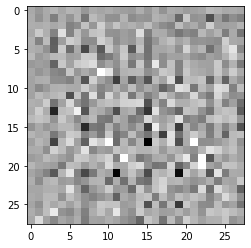

In [207]:
generator = make_generator_model()
print(generator.summary())
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
def make_discriminator_model():
    w_init = tf.random_normal_initializer(stddev=0.02)
    i = layers.Input(shape=[28,28,1])
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',activation=layers.LeakyReLU(),kernel_initializer=w_init)(i)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',activation=layers.LeakyReLU(),kernel_initializer=w_init)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1,activation='sigmoid',kernel_initializer=w_init)(x)

    model = tf.keras.Model(i,x)

    return model



In [209]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49997205]], shape=(1, 1), dtype=float32)


In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [0]:
# Build accuracy metric object for discriminator accuarcy
acc_metric = tf.keras.metrics.Accuracy() 

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
def discriminator_accuracy(real_output,fake_output):
  acc_metric.update_state(tf.ones_like(real_output),tf.round(real_output))
  real_acc = acc_metric.result()
  acc_metric.update_state(tf.zeros_like(real_output),tf.round(real_output))
  fake_acc = acc_metric.result()
  return 0.5 * (real_acc + fake_acc)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4,  0.5)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
generator_losses = []
discriminator_losses = []
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      disc_acc = discriminator_accuracy(real_output,fake_output)

      
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, disc_acc

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    batch_count = 0
    gen_loss_sum = 0
    disc_loss_sum = 0
    disc_acc_sum = 0
    for image_batch in dataset:
      gen_loss, disc_loss, disc_acc = train_step(image_batch)
      gen_loss_sum += gen_loss
      disc_loss_sum += disc_loss
      disc_acc_sum += disc_acc
      batch_count += 1

    gen_loss =  gen_loss_sum/batch_count
    disc_loss = disc_loss_sum/batch_count
    disc_acc = disc_acc_sum/batch_count
    batch_count = 0
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    
    # saves losses and accuracies
    generator_losses.append(gen_loss)
    discriminator_losses.append(disc_loss)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print('disc_loss:{:.3f}, disc_acc:{:.2f}, gen_loss:{:.3f}.'.format(disc_loss,disc_acc,gen_loss))
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

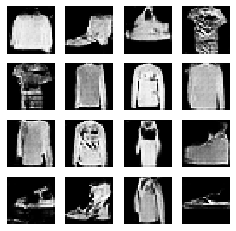

In [221]:
train(train_dataset, EPOCHS)

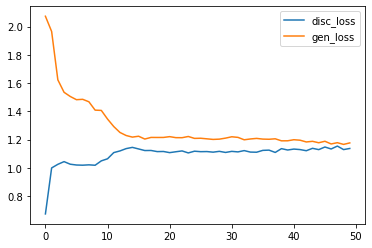

In [222]:
# plot losses
plt.plot(discriminator_losses,label='disc_loss')
plt.plot(generator_losses,label='gen_loss')
plt.legend()
plt.show()

In [223]:
# exmaple for restoring the latest checkpoint.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

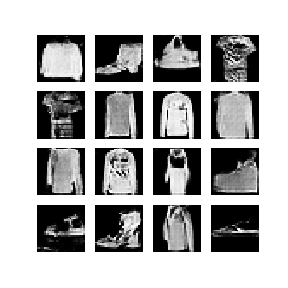

In [225]:
display_image(EPOCHS)

In [0]:
# Use imageio to create an animated gif using the images saved during training.
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
# f you're working in Colab you can download the animation with the code below:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)